# Google up: "Reanalysis Calibration"
 See paper Calibration of Reanalysis Data against Wind Measurements for Energy Production Estimation of Building Integrated Savonius-Type Wind Turbine

In [45]:
import ee

import datetime
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
from geopy.distance import great_circle

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Weather stations data

In [2]:
yMax, xMin = 54.644172, 77.134437
yMin, xMax = 50.354805, 88.087806
start = '2018-01-01'
end = '2021-01-01'

In [3]:
station_list = pd.read_csv('data/weatherstation_list.csv')

In [4]:
stations_selected = station_list[(station_list['Широта'] >= yMin) & (station_list['Широта'] <= yMax) & (station_list['Долгота'] >= xMin) & (station_list['Долгота'] <= xMax)]

selected_stations_data = pd.read_csv('data/Altai_station_data.csv')

# Setting up earth engine API

In [5]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


# Dataset selection, time period, bands, geometry 
[Link to the dataset](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY?hl=en#bands)

In [6]:
img_collection = "ECMWF/ERA5/DAILY"

bands = ['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'surface_pressure']
bands_len = len(bands)

In [7]:
start_date = datetime.datetime(year=int(start.split('-')[0]), month=int(start.split('-')[1]), day=int(start.split('-')[2]))
end_date = datetime.datetime(year=int(end.split('-')[0]), month=int(end.split('-')[1]), day=int(end.split('-')[2]))
print("Time selected")
print(start_date, " -- ", end_date)

Time selected
2018-01-01 00:00:00  --  2021-01-01 00:00:00


In [8]:
# Restricting geometry
rectangleBounds = ee.Geometry.Rectangle(
  [xMin, yMin, xMax, yMax]
)

# Casting to numpy array, dumping into dictionary

In [9]:
bands_dict = {}
for j in tqdm(range(len(bands))):
    #reading dataset band
    dataset = ee.ImageCollection(img_collection).filterBounds(rectangleBounds).filter(ee.Filter.date(start_date, end_date)).select(bands[j])
    # #resampling to get higher resolution
    band2 = dataset.toBands()#.select(bands[j])
    proj = band2.projection().getInfo()
    crs = proj['crs']
    crsTransform = proj['transform']
    tmp = dataset.getRegion(geometry=rectangleBounds, crsTransform=crsTransform).getInfo()
    tmpdf = pd.DataFrame(tmp[1:], columns = tmp[0])
    try:
        bands_df[bands[j]] = tmpdf[bands[j]]
    except NameError:
        bands_df = tmpdf

100%|██████████| 7/7 [01:49<00:00, 15.59s/it]


# Display elevation in the region selected

In [10]:
from IPython.display import Image

# Declare elevation dataset
elevation = ee.Image("CGIAR/SRTM90_V4")
lst_img = elevation.select('elevation')
# Restricting geometry
widerRectangleBounds = ee.Geometry.Rectangle(
  [xMin, yMin , xMax , yMax ]
)
# Visualisation details
url = lst_img.getThumbUrl({
    'min': -20, 'max': 2106, 'dimensions': 512, 'region': widerRectangleBounds,
    'palette': ['#386641',
            '#6a994e',
            '#a7c957',
            '#fdf7d6',
            '#ffffff']})
print(url)

# Display the thumbnail land elevation.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11d2ab843072a34484837e28e14a8434-b827165e500045ad0e8677bfd41dd735:getPixels

Please wait while the thumbnail loads, it may take a moment...


# Binding pixels to stations example

The reason to do such a thing is to construct training dataset.
Such pairs -- (reanalysis pixel, weather station) -- will allow to train a model that will translate data from reanalysis model to real measurements

## Finding closes pixel to the stations selected

/home/lukashevich/miniconda3/envs/ee/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


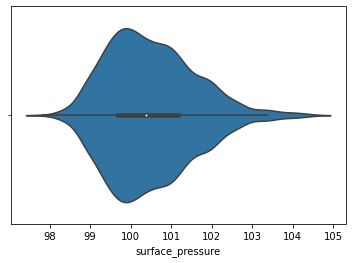

In [49]:
col = 'surface_pressure'
s = bands_df[(bands_df['longitude'] <= 79) & (bands_df['longitude'] >= 78) & (bands_df['latitude'] == 54.625)][col]
# plt.title(col)
# sm.graphics.tsa.plot_acf(s, lags=10)
# plt.savefig('acf_' + col + '.png')
# plt.show()
sns.violinplot(s/1000)
plt.savefig('violin_' + col + '.png')

In [11]:

st_pixel_dict = {}
for i in range(len(stations_selected)):
    st_coords = stations_selected[['Долгота', 'Широта']].iloc[i].values

    tmp_df = bands_df[['longitude', 'latitude']].drop_duplicates()
    idx = bands_df[['longitude', 'latitude']].drop_duplicates().apply(
        lambda x: great_circle(
            (x['longitude'], x['latitude']),
            (st_coords[0], st_coords[1])
        ).km,
        axis=1)
    tmp_df['dist'] = idx

    tmp_df.nsmallest(1, columns=['dist'])

    st_pixel_dict[stations_selected['Наименование станции'].iloc[i]] = tmp_df.nsmallest(1, columns=['dist'])[['longitude', 'latitude']]

## Extracting reanalysis data corresponding to pixels that contain a station

In [12]:
k_ = list(st_pixel_dict.keys())[0]
dataset_stations = {}
vicinity_degree = 1.0 #neighboring pixels to collect for a station
X_data = {}
for k_ in st_pixel_dict.keys():
    curr_pix = st_pixel_dict[k_]
    curr_pix_lon = curr_pix['longitude'].values[0]
    curr_pix_lat = curr_pix['latitude'].values[0]
    #collecting neghboring pixels
    station_era = bands_df[(bands_df['longitude'] <= curr_pix_lon + vicinity_degree) 
            & (bands_df['latitude'] <= curr_pix_lat + vicinity_degree) 
            & (bands_df['longitude'] >= curr_pix_lon - vicinity_degree) 
            & (bands_df['latitude'] >= curr_pix_lat - vicinity_degree)]    
    station_era['id'] = pd.to_datetime(station_era['id'], format="%Y/%m/%d").values

    
    dataset_stations[k_] = station_era.drop(columns='time')

/tmp/ipykernel_20841/4287271505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_era['id'] = pd.to_datetime(station_era['id'], format="%Y/%m/%d").values
/tmp/ipykernel_20841/4287271505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_era['id'] = pd.to_datetime(station_era['id'], format="%Y/%m/%d").values
/tmp/ipykernel_20841/4287271505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## Wrap up together


In [13]:
for k_ in dataset_stations.keys():
    curr_station_data = selected_stations_data[selected_stations_data['Название метеостанции'] == k_]
    curr_station_avg_ws = curr_station_data[['Дата', 'Средняя скорость ветра']].rename(columns={'Дата': 'id'})
    curr_station_avg_ws.loc[:, 'id'] = curr_station_avg_ws['id'].astype('str')
    dataset_stations[k_].loc[:, 'id'] = dataset_stations[k_]['id'].astype('str')
    start_era_date = dataset_stations[k_].min()
    last_era_date = dataset_stations[k_].max()
    station_data = curr_station_avg_ws[(curr_station_avg_ws.id <= last_era_date.values[0]) & (curr_station_avg_ws.id >= start_era_date.values[0])]
    
    dataset_stations[k_] = [dataset_stations[k_], station_data.groupby('id').max()]
# Xy_station = pd.merge(curr_station_avg_ws, dataset_stations[k_], how='inner', on='id')

In [33]:
lon_len_dict = {}
max_lon = 0
max_lat = 0
for k_ in dataset_stations.keys():
    lon_len = len(dataset_stations[k_][0].longitude.unique())
    lat_len = len(dataset_stations[k_][0].latitude.unique())
    if max_lon <= lon_len:
        max_lon = lon_len
    if max_lat <= lat_len:
        max_lat = lat_len
    lon_len_dict[k_] = (lon_len, lat_len)
for k_ in dataset_stations.keys():
    if lon_len_dict[k_][0] != max_lon or lon_len_dict[k_][1] != max_lat:
        del lon_len_dict[k_]

In [34]:
if not os.path.exists(os.path.join('data', 'nn_data')):
    os.makedirs(os.path.join('data', 'nn_data'))
for k_ in lon_len_dict.keys():
    if not os.path.exists(os.path.join('data', 'nn_data', k_)):
        os.makedirs(os.path.join('data', 'nn_data', k_))
    #with open(os.path.join('data', 'nn_data', k_)) as 
    dataset_stations[k_][0].to_csv(os.path.join('data', 'nn_data', k_, 'objects.csv'))
    dataset_stations[k_][1].to_csv(os.path.join('data', 'nn_data', k_, 'targets.csv'))

# Summary
* In this simple example we have downloaded reanalysis data from Google Earth Engine. We also bound this data to weather stations measurements on a pixel basis with its vicinity.

* The next steps will be 
> a. Prepare this data to insert into ML/DL pipeline for training.

> b. Develop a ML/DL model that will train on this data and learn how to translate reanalysis data to the real measurements from weather stations.

* See `train_model.ipynb`

* After the model is trained, one can obtain refined model at any pixel of interest.